# 폐렴 진단

data : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
- 폐렴 : x-ray 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰됨

<br><br><br><br>

# 1. set up

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

<br><br><br><br>

# 2. 데이터 로드

In [5]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames), len(test_filenames), len(val_filenames))

5216 624 16


- **validation data 갯수가 너무 부족하여 train과 val을 합쳐 80:20으로 나누기**

In [8]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))
print(len(filenames))

5232


In [10]:
# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)
print(len(train_filenames), len(val_filenames))

4185 1047


- **train data 안에 정상, 폐렴 이미지 수 체크**

In [11]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1092
Pneumonia images count in training set: 3093


- **tf.data 인스턴스 생성**

In [12]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [13]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


- **라벨 확인**

In [14]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] 
                       for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])

print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


<br><br><br><br>

# 3. 데이터 전처리

- **라벨이 이미지이름에만 있기 때문에 라벨을 붙여주는 함수**

In [15]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    print(parts)
    return parts[-2] == "PNEUMONIA"  # 폐렴이면 양성(True), 노멀이면 음성(False)을 리턴

- **이미지 사이즈 통일 및 축소 함수**

In [16]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # img를 unit8 tensor로 변경
    img = tf.image.convert_image_dtype(img, tf.float32)  # img를 범위 [0,1]의 float32 타입으로 변경
    return tf.image.resize(img, IMAGE_SIZE)  # 이미지 사이즈 변경 IMAGE_SIZE = [180, 180]

- **이미지 path로 라벨, 사이즈 처리**

In [17]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

- **train, validation 데이터셋 만들기**

In [24]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)


In [25]:
for image, label in train_ds.take(1):
    print("Image shape : ", image.numpy().shape)
    print("Lable : ", label.numpy())

Image shape :  (180, 180, 3)
Lable :  False


- **test 데이터셋 처리**

In [27]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
print(TEST_IMAGE_COUNT)

Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
624


In [29]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

- **데이터 시각화**

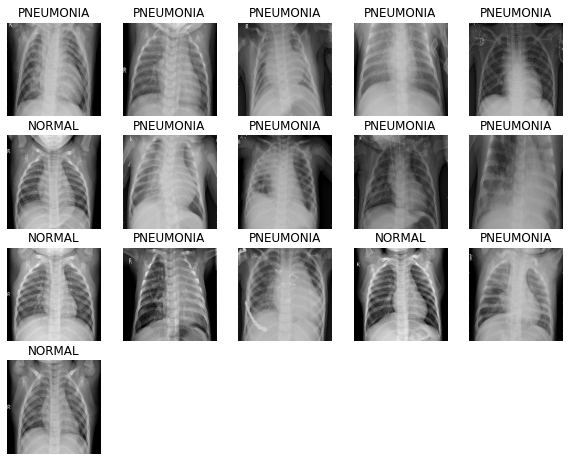

In [31]:
# train에 있는 batch 중 첫번째 배치 추출하여 image와 label로 나눔
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

<br><br><br><br>

# 4. 모델 설계
CNN

In [40]:
# Convolution block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    return block

# Dense block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [41]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

<br><br><br><br>

# 5. Weight balancing
특정 라벨이 너무 많아 데이터의 밸런스가 맞지 않은 경우(imbalance) Weight balancing을 사용할 수 있다. Weight balancing은 training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다.

In [35]:
weight_for_0 = (1/COUNT_NORMAL) * (TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.92
Weight for class 1: 0.68


<br><br><br><br>

# 6. 모델 훈련

In [42]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [43]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 26s 99ms/step - loss: 0.3955 - accuracy: 0.8182 - precision: 0.9497 - recall: 0.7962 - val_loss: 0.5850 - val_accuracy: 0.7548 - val_precision: 0.7548 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 86ms/step - loss: 0.2347 - accuracy: 0.9124 - precision: 0.9752 - recall: 0.9045 - val_loss: 0.9676 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 23s 87ms/step - loss: 0.2101 - accuracy: 0.9148 - precision: 0.9746 - recall: 0.9083 - val_loss: 0.1106 - val_accuracy: 0.9558 - val_precision: 0.9512 - val_recall: 0.9924
Epoch 4/25
261/261 [==============================] - 23s 87ms/step - loss: 0.1890 - accuracy: 0.9279 - precision: 0.9751 - recall: 0.9261 - val_loss: 0.1091 - val_accuracy: 0.9567 - val_precision: 0.9501 - val_recall: 0.9949
Epoch 5/25
261/261 [==============================] - 22s 85ms/step - loss: 0.1717 - accuracy: 0

<br><br><br><br>

# 7. 결과

- **epoch마다 모델의 precision, recall, accuracy, loss이 어떻게 변하는지 그래프 출력**

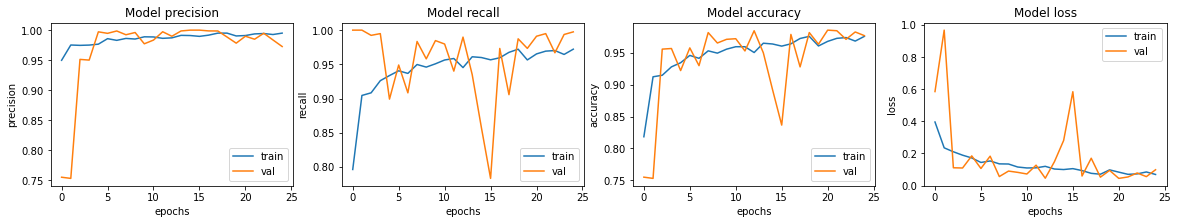

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- **test 데이터로 모델 평가**

In [45]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 61ms/step - loss: 1.7010 - accuracy: 0.7212 - precision: 0.6915 - recall: 1.0000
